In [1]:
import os, torch, torch, tqdm
import sys, json
import h5py
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE

sys.path.append("/home/zhang_istbi/data_disk/zhaobt/projects/tumor_cls/")

from nets import Losses
from utils import data_generator
from nets import unet, resnet
from utils import file_io
from utils import logger
from utils import model_io

# prepare for inference

In [2]:
def acc(pred, y_true):
    res = 0
    for p, t in zip(pred, y_true):
        if p == t:
            res += 1
    return res/len(pred)

def cal_cls_res(label, pred, prob=None):
    p = precision_score(label, pred, average='binary')
    r = recall_score(label, pred, average='binary')
    f1score = f1_score(label, pred, average='binary')
    print("acc:", np.sum(np.array(label)==np.array(pred))/len(pred))
    print("precision_score:", p)
    print("recall_score:", r)
    print("f1_score:", f1score)
    if prob is not None:
        fpr,tpr,threshold = roc_curve(label,prob) ###计算真正率和假正率
        roc_auc = auc(fpr,tpr)
        print("roc_auc:", roc_auc)

In [3]:
model = unet.Unet_cls("resnext101_32x16d", 2, 2)

In [4]:
labeled_f_val = h5py.File(r"../../../dataset/tumor_cls/cross_val_h5_dataset/fold1_2d_mix_test.h5", 'r')
labels_all = labeled_f_val['label'][:]
imgs= labeled_f_val['img'][:]
masks = labeled_f_val['mask'][:]
indexs = labeled_f_val['meta_info'][:]
labeled_f_val.close()

In [5]:
labels = np.zeros_like(labels_all)
labels[labels_all == 3] = 1
val_cls_dataset = data_generator.cls_generator_2D(imgs,
                                                  masks, labels,
                                                  rotate_degree=0,
                                                  noise_sigma=(0, 1e-9), )
val_dataLoader = DataLoader(val_cls_dataset, batch_size=1, shuffle=False)

In [6]:
print(len(val_dataLoader))
# print(len(pred))

2310


In [7]:
path = "../cpts/cls_maoxing//resnest101_2d_cls_seg_fold1/model_cls_dice/15_model.pth"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# inference

In [8]:
def merge_slice(index, pred, labels):
    data = {}
    label = []
    temp = -1
    temp_l = -1
    for idx, i in enumerate(index):
        if temp != i:
            temp = i
            label.append(labels[idx])
        if temp not in data:
            data[temp] = [pred[idx]]
        else:
            data[temp].append(pred[idx])
    return data, label

In [9]:
def evaluate(model, val_dataLoader):
    model.eval()
    model.cuda()
    pred = []
    pres_prob = []
    for idx, data in tqdm.tqdm(enumerate(val_dataLoader)):
        img, tumor, label = data
        img = img.cuda()
        seg, pred_label = model(img)
        pred_label_prob = F.softmax(pred_label, dim=1)
        pred.append(torch.max(pred_label, dim=1)[1].item())
        pres_prob.append(pred_label_prob[0, 1].item())
    return pred, pres_prob
pred, pres_prob = evaluate(model, val_dataLoader)

2310it [02:15, 17.09it/s]


In [10]:
cal_cls_res(labels, pred, pres_prob)
savedir = "../cpts/cls_maoxing/resnest101_2d_cls_seg_fold1"
np.save(savedir +"/dice_pred-train-epoch15", pres_prob)

acc: 0.24415584415584415
precision_score: 0.176266137040715
recall_score: 0.8031674208144797
f1_score: 0.2890879478827362
roc_auc: 0.4654117453273519


In [12]:
np.sum(pred)/len(pred)

0.8718614718614719

# vote

## voting by number

In [92]:
def votingBynum(data, cls_bound):
    pred_case = []
    prob_case = []
    for i in data:
        prob_case.append(sum(data[i])/len(data[i]))
        if sum(data[i])/len(data[i]) > cls_bound:
            pred_case.append(1)
        else:
            pred_case.append(0)
    return pred_case, prob_case

data, label = merge_slice(indexs, pred, labels)
max_acc = 0
max_bound = 0
for i in np.arange(0,1,0.01):
    pred_case_temp, _ = votingBynum(data, i)
    if acc(label, pred_case_temp) > max_acc:
        max_acc = acc(label, pred_case_temp)
        max_bound = i
opt_pred, mean_prob= votingBynum(data, max_bound)
opt_pred, mean_prob= votingBynum(data, max_bound)
cal_cls_res(label, opt_pred, mean_prob)
max_bound

acc: 0.8352941176470589
precision_score: 0.6666666666666666
recall_score: 0.13333333333333333
f1_score: 0.2222222222222222
roc_auc: 0.7533333333333333


0.93

## voting by weight

In [94]:
def votingByprob(pres_prob_case2, cls_bound):
    pred_case_2 = []
    prob_case_2 = []
    for idx, i in enumerate(pres_prob_case2):
    #     print(idx, i, label[i], np.mean(pres_prob_case2[i]))
        prob_case_2.append(np.mean(pres_prob_case2[i]))
        if np.mean(pres_prob_case2[i])> cls_bound:
            pred_case_2.append(1)
        else:
            pred_case_2.append(0)
    return pred_case_2, prob_case_2

pres_prob_case2, label = merge_slice(indexs, pres_prob, labels)
max_acc = 0
max_bound = 0
for i in np.arange(0,1,0.01):
    pred_case_temp, _ = votingByprob(pres_prob_case2, i)
    if acc(label, pred_case_temp) > max_acc:
        max_acc = acc(label, pred_case_temp)
        max_bound = i
opt_pres, mean_prob = votingByprob(pres_prob_case2, max_bound)
opt_pres, mean_prob = votingByprob(pres_prob_case2, 0.7)
cal_cls_res(label, opt_pres, np.array(mean_prob))
max_bound

acc: 0.8
precision_score: 0.375
recall_score: 0.2
f1_score: 0.26086956521739135
roc_auc: 0.7504761904761905


0.93

In [83]:
opt_pres

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

# VIS

<Figure size 432x288 with 0 Axes>

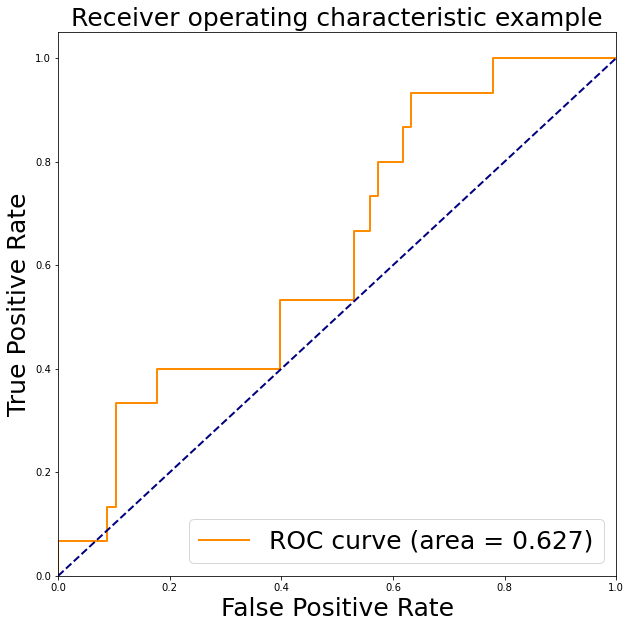

In [22]:
def acu_curve(y,prob):
    fpr,tpr,threshold = roc_curve(y,prob) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
 
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=25)
    plt.ylabel('True Positive Rate', fontsize=25,)
    plt.title('Receiver operating characteristic example', fontsize=25,)
    plt.legend(loc="lower right", fontsize=25)
 
    plt.show()
# softmax_pred = xgb1.predict_proba(X_test)
acu_curve(np.array(label),np.array(mean_prob))

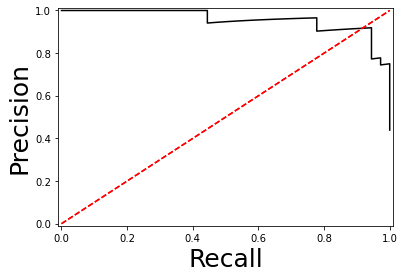

In [25]:
def PR_curve(y,pred):
    pos = np.sum(y == 1)
    neg = np.sum(y == 0)
    pred_sort = np.sort(pred)[::-1]  # 从大到小排序
    index = np.argsort(pred)[::-1]  # 从大到小排序
    y_sort = y[index]
#     print(y_sort)

    Pre = []
    Rec = []
    for i, item in enumerate(pred_sort):
        if i == 0:#因为计算precision的时候分母要用到i，当i为0时会出错，所以单独列出
            Pre.append(1)
            Rec.append(0)
        else:
            Pre.append(np.sum((y_sort[:i] == 1)) /i)
            Rec.append(np.sum((y_sort[:i] == 1)) / pos)
#     print(Pre)
#     print(Rec)
    ## 画图
    plt.plot(Rec, Pre, 'k')
    # plt.legend(loc='lower right')
#     plt.title('Receiver Operating Characteristic')
    plt.plot([(0, 0), (1, 1)], 'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 01.01])
    plt.ylabel('Precision', fontsize=25)
    plt.xlabel('Recall', fontsize=25)
    plt.show()
PR_curve(np.array(label),np.array(mean_prob))

# get vec to multiclass

In [30]:
model.eval()
model.cuda()
pred_val_vec = []

for idx, data in tqdm.tqdm(enumerate(val_dataLoader)):
    img, tumor, label = data
    img = img.cuda()
    cls_vec = model.get_vec(img)
    pred_val_vec.append(cls_vec.detach().cpu().numpy())


2310it [00:50, 45.88it/s]


In [31]:
# def val_model(model, val_dataset, use_cuda):
    # implemented
model.eval()
model.cuda()
pred_train_vec = []

for idx, data in tqdm.tqdm(enumerate(train_dataLoader)):
    img, tumor, label = data
    img = img.cuda()
    cls_vec = model.get_vec(img)
    pred_train_vec.append(cls_vec.detach().cpu().numpy())
    
# print("==>VAL:  dice: {}, acc: {}".format(acc(pred, y_true)))
# return dices.avg, pred, pres_prob

9289it [03:38, 42.60it/s]


In [33]:
pred_val_vec = np.array(pred_val_vec)
savedir = "../cpts/cls/resnest101_2d_cls_seg_fold1"
np.save(savedir +"/vec-test-epoch100", pred_val_vec)

pred_train_vec = np.array(pred_train_vec)
savedir = "../cpts/cls/resnest101_2d_cls_seg_fold1"
np.save(savedir +"/vec-train-epoch100", pred_train_vec)

In [12]:
pred_val_vec.shape

(2310, 2048)

In [20]:
pred_train_vec = np.array(pred_train_vec)
pred_train_vec.shape

(8956, 2048)

/home/zhang_istbi/miniconda3/envs/pt10/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/zhang_istbi/miniconda3/envs/pt10/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:593: RuntimeWarning: overflow encountered in square
  self.explained_variance_ = (S ** 2) / (n_samples - 1)
/home/zhang_istbi/miniconda3/envs/pt10/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(2310, 2)


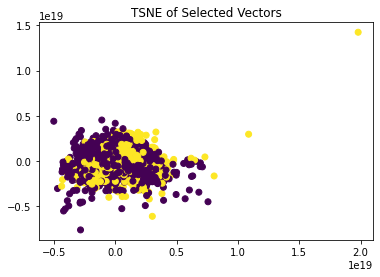

In [34]:
tsne2 = TSNE(n_components=2, init='pca', random_state=501)
tsne_nore = tsne2.fit_transform(pred_val_vec)
print(tsne_nore.shape)
plt.scatter(tsne_nore[:,0],tsne_nore[:,1],c=labels)
plt.title("TSNE of Selected Vectors")
# plt.legend()
plt.show()

12.2054205
0.00066135504


/home/zhang_istbi/miniconda3/envs/pt10/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/zhang_istbi/miniconda3/envs/pt10/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:593: RuntimeWarning: overflow encountered in square
  self.explained_variance_ = (S ** 2) / (n_samples - 1)
/home/zhang_istbi/miniconda3/envs/pt10/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


0.17702353
(2289, 2)


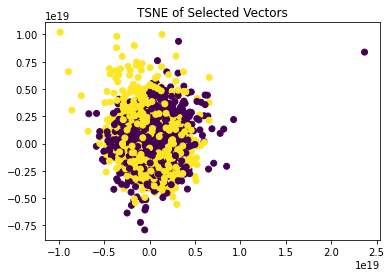

In [35]:
print(np.max(pred_train_vec))
print(np.min(pred_train_vec))
# pred_train_vec = np.nan_to_num(pred_train_vec)

pred_train_vec_norm = F.normalize(torch.from_numpy(pred_train_vec), dim=1).numpy()
tsne2 = TSNE(n_components=2, init='pca', random_state=501)
tsne_nore = tsne2.fit_transform(pred_train_vec_norm[7000:, :])
print(np.max(pred_train_vec_norm))

print(tsne_nore.shape)
plt.scatter(tsne_nore[:,0],tsne_nore[:,1],c=train_labels[7000:])
plt.title("TSNE of Selected Vectors")
# plt.legend()
plt.show()

# read age info

In [36]:
data = open("../data/name_age/age_dataset.json", "r")
age_dataset = json.load(data)
data.close()
stat_ages = {}
for i in age_dataset:
    temp = []
    for j in age_dataset[i]:
        temp.append(age_dataset[i][j])
    print(i, np.mean(temp),"±",np.std(temp))
    stat_ages[i] = np.mean(temp)

hemangioblastoma 45.09051724137931 ± 13.8811300745384
pilocytic_astrocytoma 23.631944444444443 ± 13.598788001436917
angiocavernoma 38.78861788617886 ± 13.925616585155332
III-IV_glioma 32.57142857142857 ± 18.630674727886976


In [39]:
def get_ageset_for_slice(data_dir, train_indexs):
    age_set = {}
    with open(data_dir, 'r') as f:
        strs = f.readlines()
    #     print(strs)
        mask_list = [line.strip().split(" ")[0] for line in strs]
        tumor_type_name = []
        for idx, i in enumerate(mask_list):
            name = i.split("/")
            try:
#                 print(idx, age_dataset[name[7]][name[8]])
                age_set[idx] = age_dataset[name[7]][name[8]]
            except:
                print(idx, i)
                age_set[idx] = stat_ages[name[7]]
                tumor_type_name.append((name[7], name[8]))
    age_slices = []
    for idx, i in enumerate(train_indexs):
        age_slices.append(age_set[i])
    return age_slices

data_dir = "../data/version_mix/fold1/train.txt"
train_age_slices = get_ageset_for_slice(data_dir, train_indexs)
print("===> TEST")
data_dir = "../data/version_mix/fold1/test.txt"
test_age_slices = get_ageset_for_slice(data_dir, indexs)

43 /home/zhang_istbi/zhaobt/dataset/tumor_cls/tumor_dataset1/hemangioblastoma/lv_wen_ying/T1+/T1+_T1_MPRAGE_TRA_iso1.0_20130327102248_2_roi_resize_crop.nii.gz
59 /home/zhang_istbi/zhaobt/dataset/tumor_cls/tumor_dataset2/III-IV_glioma/xu_bo_wen/xu_bo_wen_WIP_T1W_3D_Nav+C_20200330201120_501_T1+_roi_resize_crop.nii.gz
84 /home/zhang_istbi/zhaobt/dataset/tumor_cls/tumor_dataset2/III-IV_glioma/peng_zi_xuan/peng_zi_xuan_OAx_T1Flair+C_20200914210820_9_T1+_roi_resize_crop.nii.gz
123 /home/zhang_istbi/zhaobt/dataset/tumor_cls/tumor_dataset3/hemangioblastoma/lin_yan_ming/T1+/_j201406__1213042732/_j201406__1213042732_Ax_T1+C_20210816164431_6_roi_resize_crop.nii.gz
138 /home/zhang_istbi/zhaobt/dataset/tumor_cls/tumor_dataset1/hemangioblastoma/wang_jian_bing_2/T1+/t1+_T1_MPRAGE_TRA_iso1.0_20191016131331_9_roi_resize_crop.nii.gz
149 /home/zhang_istbi/zhaobt/dataset/tumor_cls/tumor_dataset2/III-IV_glioma/wang_you_ding/wang_you_ding_OAx_T1Flair+C_20190216083825_9_T1+_roi_resize_crop.nii.gz
188 /home/z

# cls by vec

##  特征工程

In [41]:
savedir = "../cpts/cls/resnest101_2d_cls_seg_fold1"
train_X = np.load(savedir +"/vec-train-epoch100.npy")

pred_train_vec = np.array(pred_train_vec)
savedir = "../cpts/cls/resnest101_2d_cls_seg_fold1"
test_X = np.load(savedir +"/vec-test-epoch100.npy")

In [42]:
from sklearn.decomposition import PCA
estimator = PCA(n_components=12)
pca = estimator.fit(train_X)
pca_X_train = pca.transform(train_X)
pca_X_test = pca.transform(test_X)
pca_X_train.shape

(9289, 12)

In [43]:
test_X.shape
# len(age_slices)

(2310, 2048)

In [44]:
train_age_slices = np.reshape(np.array(train_age_slices),(9289,1))
train_X=np.concatenate([train_X, train_age_slices], axis=1)
train_Y = train_labels

test_age_slices = np.reshape(np.array(test_age_slices),(2310,1))
test_X=np.concatenate([test_X, test_age_slices], axis=1)
test_Y = labels
test_Y.shape

(2310,)

In [45]:
train_age_slices = np.reshape(np.array(train_age_slices),(9289,1))
pca_train_X=np.concatenate([pca_X_train, train_age_slices], axis=1)
train_Y = train_labels

test_age_slices = np.reshape(np.array(test_age_slices),(2310,1))
pca_test_X=np.concatenate([pca_X_test, test_age_slices], axis=1)
test_Y = labels
test_Y.shape

(2310,)

## 测试

In [48]:
import xgboost as xgb
from xgboost import XGBClassifier

In [47]:
xgb1=XGBClassifier(
    )
# print(Y_test.shape)
xgb1.fit(train_X,train_Y)


/home/zhang_istbi/miniconda3/envs/pt10/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [49]:
xgb2=XGBClassifier(
    )
# print(Y_test.shape)
xgb2.fit(pca_train_X,train_Y)
predicted=xgb2.predict(pca_test_X)

[15:06:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [54]:
predicted=xgb1.predict(test_X)
softmax_pred = xgb1.predict_proba(test_X)
cal_cls_res(test_Y, predicted, softmax_pred[:, 1])

acc: 0.8090909090909091
precision_score: 0.7946954813359528
recall_score: 0.777137367915466
f1_score: 0.7858183584264207
roc_auc: 0.8884729252726474


In [51]:
xgb2.feature_importances_

array([0.7790721 , 0.13566989, 0.00401429, 0.00826633, 0.00581783,
       0.00678129, 0.00800504, 0.00821997, 0.01478352, 0.00503936,
       0.00488838, 0.00662553, 0.01281649], dtype=float32)

<BarContainer object of 13 artists>

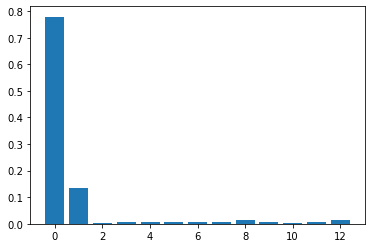

In [52]:
plt.bar(np.arange(13),xgb2.feature_importances_ )